In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data = pd.read_csv("CA_data.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [18]:
# Check missing values as a percentage
missing_percentage = train.isna().sum() / len(train)
print(missing_percentage)

trip_seconds                       0.000000
trip_miles                         0.000000
pickup_community_area              0.000000
dropoff_community_area             0.000000
fare                               0.000100
tips                               0.000100
extras                             0.000100
trip_total                         0.000100
company                            0.000000
pickup_centroid_latitude           0.000000
pickup_centroid_longitude          0.000000
dropoff_centroid_latitude          0.000000
dropoff_centroid_longitude         0.000000
is_working_day                     0.000000
is_rush_hour                       0.000000
pickup_community_area_mode         0.013535
dropoff_community_area_mode        0.013425
pickup_centroid_latitude_mode      0.013400
pickup_centroid_longitude_mode     0.013400
dropoff_centroid_latitude_mode     0.013425
dropoff_centroid_longitude_mode    0.013425
dtype: float64


In [13]:
# Define public holidays
public_holidays = [
    "2018-01-01", "2018-01-15", "2018-02-19", "2018-03-05", "2018-05-28",
    "2018-07-04", "2018-09-03", "2018-10-08", "2018-11-11", "2018-11-22",
    "2018-12-25", "2018-02-12", "2019-01-01", "2019-01-21", "2019-02-18",
    "2019-03-04", "2019-05-27", "2019-07-04", "2019-09-02", "2019-10-14",
    "2019-11-11", "2019-11-28", "2019-12-25", "2019-02-12"
]

# Convert trip_start_timestamp to datetime
train['trip_start_timestamp'] = pd.to_datetime(train['trip_start_timestamp'])

# Add is_working_day
train['is_working_day'] = np.where(
    (train['trip_start_timestamp'].dt.weekday.isin(range(0, 5))) & 
    (~train['trip_start_timestamp'].dt.strftime('%Y-%m-%d').isin(public_holidays)), 
    1, 0
)

# Add is_rush_hour
train['is_rush_hour'] = np.where(
    ((train['trip_start_timestamp'].dt.hour.isin([7, 8, 9]) &
      (train['trip_start_timestamp'].dt.minute <= 59)) |
     (train['trip_start_timestamp'].dt.hour.isin([16, 17, 18]) &
      (train['trip_start_timestamp'].dt.minute <= 59))) &
    (train['is_working_day'] == 1),
    1, 0
)

In [14]:
# Fill missing values for numeric columns with mode
for col in ['trip_seconds', 'trip_miles']:
    train[col] = train[col].fillna(train[col].mode()[0])

In [15]:
# Function to get mode
def get_mode(series):
    return series.mode().iloc[0] if not series.mode().empty else np.nan

# Group by taxi_id and calculate modes
modes = train.groupby('taxi_id').agg({
    'pickup_community_area': get_mode,
    'dropoff_community_area': get_mode,
    'pickup_centroid_latitude': get_mode,
    'pickup_centroid_longitude': get_mode,
    'dropoff_centroid_latitude': get_mode,
    'dropoff_centroid_longitude': get_mode
}).reset_index()

# Merge with train
train = train.merge(modes, on='taxi_id', suffixes=('', '_mode'))

# Fill missing values with group modes
for col in [
    'pickup_community_area', 'dropoff_community_area',
    'pickup_centroid_latitude', 'pickup_centroid_longitude',
    'dropoff_centroid_latitude', 'dropoff_centroid_longitude'
]:
    train[col] = train[col].fillna(train[f"{col}_mode"]).fillna(0)

In [16]:
# Drop unnecessary columns
train = train.drop(columns=[
    'taxi_id', 'trip_start_timestamp', 'trip_end_timestamp', 
    'payment_type', 'tolls', 'id'
])

In [17]:
# Encode categorical columns
for col in train.select_dtypes('object').columns:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])

In [38]:
# Split data into training, validation, and test sets
X = train.drop(columns=['is_rush_hour'])
y = train['is_rush_hour']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)

In [39]:
# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

# Train XGBoost model
xgb_model = xgb.train(
    {
        'max_depth': 5,
        'eta': 0.2,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist',
    },
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=200
)

[0]	train-auc:0.74986	val-auc:0.74917
[1]	train-auc:0.75419	val-auc:0.75507
[2]	train-auc:0.76153	val-auc:0.76271
[3]	train-auc:0.76926	val-auc:0.77031
[4]	train-auc:0.77231	val-auc:0.77344
[5]	train-auc:0.77532	val-auc:0.77637
[6]	train-auc:0.77712	val-auc:0.77789
[7]	train-auc:0.77838	val-auc:0.77880
[8]	train-auc:0.78246	val-auc:0.78265
[9]	train-auc:0.78363	val-auc:0.78368
[10]	train-auc:0.78429	val-auc:0.78401
[11]	train-auc:0.78647	val-auc:0.78556
[12]	train-auc:0.78769	val-auc:0.78658
[13]	train-auc:0.78885	val-auc:0.78774
[14]	train-auc:0.79055	val-auc:0.78928
[15]	train-auc:0.79109	val-auc:0.78962
[16]	train-auc:0.79172	val-auc:0.78994
[17]	train-auc:0.79262	val-auc:0.79059
[18]	train-auc:0.79330	val-auc:0.79106
[19]	train-auc:0.79375	val-auc:0.79137
[20]	train-auc:0.79416	val-auc:0.79169
[21]	train-auc:0.79481	val-auc:0.79188
[22]	train-auc:0.79533	val-auc:0.79205
[23]	train-auc:0.79625	val-auc:0.79275
[24]	train-auc:0.79672	val-auc:0.79306
[25]	train-auc:0.79696	val-auc:0.79

In [32]:
# Predict on test set
y_pred = xgb_model.predict(dtest)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Confusion matrix and metrics
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# AUC Score
auc_score = roc_auc_score(y_test, y_pred)
print(f"AUC: {auc_score:.4f}")

Confusion Matrix:
[[19851  1934]
 [ 5247  2968]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.91      0.85     21785
           1       0.61      0.36      0.45      8215

    accuracy                           0.76     30000
   macro avg       0.70      0.64      0.65     30000
weighted avg       0.74      0.76      0.74     30000

AUC: 0.8026


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


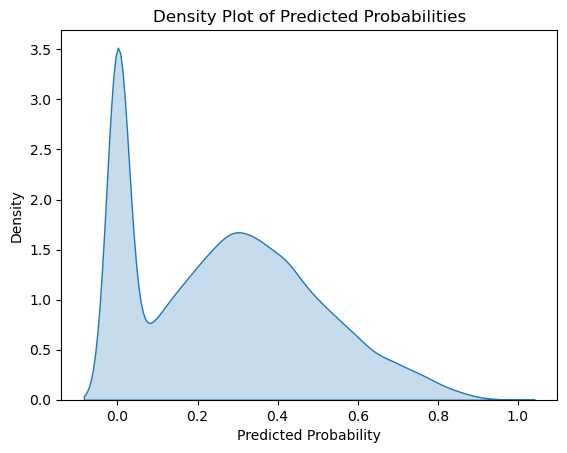

In [33]:
# Plot density of predictions
sns.kdeplot(y_pred, label="Predicted Probabilities", fill=True)
plt.title("Density Plot of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.show()

In [34]:
# Predict probabilities on the test set
y_pred_prob_xgb = xgb_model.predict(dtest)

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred_xgb = (y_pred_prob_xgb >= 0.5).astype(int)

In [35]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:")
print(conf_matrix_xgb)

# Extract TN, FP, FN, TP
TN, FP, FN, TP = conf_matrix_xgb.ravel()

Confusion Matrix:
[[19851  1934]
 [ 5247  2968]]


In [36]:
# Calculate recall for each class
recall_class_0 = TN / (TN + FP)  # Recall for class 0
recall_class_1 = TP / (TP + FN)  # Recall for class 1

# Calculate balanced accuracy
balanced_accuracy_xgb = (recall_class_0 + recall_class_1) / 2
print(f"Balanced Accuracy: {balanced_accuracy_xgb:.4f}")

Balanced Accuracy: 0.6363


In [37]:
from sklearn.metrics import balanced_accuracy_score

# Calculate balanced accuracy
balanced_accuracy_xgb = balanced_accuracy_score(y_test, y_pred_xgb)
print(f"Balanced Accuracy (Sklearn): {balanced_accuracy_xgb:.4f}")

Balanced Accuracy (Sklearn): 0.6363


## TRAIN WITH LG INSTEAD

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

In [19]:
# Check missing values as a percentage
missing_percentage = train.isna().sum() 
#missing_percentage = train.isna().sum() / len(train)

print(missing_percentage)

trip_seconds                          0
trip_miles                            0
pickup_community_area                 0
dropoff_community_area                0
fare                                 20
tips                                 20
extras                               20
trip_total                           20
company                               0
pickup_centroid_latitude              0
pickup_centroid_longitude             0
dropoff_centroid_latitude             0
dropoff_centroid_longitude            0
is_working_day                        0
is_rush_hour                          0
pickup_community_area_mode         2707
dropoff_community_area_mode        2685
pickup_centroid_latitude_mode      2680
pickup_centroid_longitude_mode     2680
dropoff_centroid_latitude_mode     2685
dropoff_centroid_longitude_mode    2685
dtype: int64


In [21]:
# Define features (X) and target variable (y)
X = train.drop(columns=['is_rush_hour'])
y = train['is_rush_hour']

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)

In [22]:
# Initialize logistic regression model
logreg_model = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
logreg_model.fit(X_train, y_train)

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# Predict on the validation set
y_val_pred = logreg_model.predict(X_val)
y_val_pred_prob = logreg_model.predict_proba(X_val)[:, 1]  # Predicted probabilities for the positive class

In [ ]:
# Accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

# AUC (Area Under the ROC Curve)
auc = roc_auc_score(y_val, y_val_pred_prob)
print(f"Validation AUC: {auc:.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(conf_matrix)

In [ ]:
# Predict on the test set
y_test_pred = logreg_model.predict(X_test)
y_test_pred_prob = logreg_model.predict_proba(X_test)[:, 1]

# Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# AUC
test_auc = roc_auc_score(y_test, y_test_pred_prob)
print(f"Test AUC: {test_auc:.4f}")

# Classification Report
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Test Confusion Matrix:")
print(conf_matrix_test)

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)

# Plot ROC curve
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

In [ ]:
import seaborn as sns

# Heatmap for Confusion Matrix
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Rush', 'Rush'], yticklabels=['Non-Rush', 'Rush'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Set Confusion Matrix")
plt.show()